# Improving Brewster Paper

In the original paper **General characterization of qubit-preserving impairments on two-qubit Bell nonlocality**, a technique was presented that would correct errors such as polarization misalignments of entangled qubits by optimizing a set of unitary gets for each of the qubits Alice and Bob have. A follow up paper, **Automated Bell inequality violation searches for estimating entanglement quality in fiber**, determined that the Nelder-Mead Method was deemed to be the best method for optimization, though Bayesian Optimization was also quoted as being a close second. 

Previous work on this repo has simulated CHSH games on a quantum network using SeQuEnCe, with more recent additions implementing polarization misalignment and the proposed corrective technique by the above papers. However, we believe that we can improve this process further by utilizing more suitable optimization techniques. The below experiment uses COnstrained Optimization BY Linear Approximation, or COBYLA, to better approximate better alphas in a noisy quantum environment.  

In [1]:
import network_module
from scipy.optimize import minimize
import numpy as np

In [2]:
theta1 = 0.7854          
theta2 = 0          
theta3 = -0.3927        
theta4 = 0.3927

In [8]:
from bayes_opt import BayesianOptimization
import numpy as np
import time

def BayesOPT(deltas, time_limit=400, precision=2500):
    iteration_s_values = []
    time_values = []
    winrate_best = -np.inf
    best_S = 0
    start_time = time.time()

    # Define the CHSH evaluation function with timing and logging
    def simulated_chsh(alpha1, alpha2, alpha3, alpha4, alpha5, alpha6):
        nonlocal best_S,winrate_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit exceeded")

        g = network_module.Game(deltas=deltas, fid=0.9)
        alphas_alice = [alpha1, alpha2, alpha3]
        alphas_bob = [alpha4, alpha5, alpha6]
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        # print(winrate)
        S = g.referee.compute_chsh_s()

        # Log best-so-far S and corresponding timestamp
        if winrate > winrate_best:
            winrate_best = winrate
            best_S = S
        iteration_s_values.append(best_S)
        time_values.append(elapsed)

        return winrate

    # Define bounds
    pbounds = {
        'alpha1': (-np.pi, np.pi),
        'alpha2': (-np.pi, np.pi),
        'alpha3': (-np.pi, np.pi),
        'alpha4': (-np.pi, np.pi),
        'alpha5': (-np.pi, np.pi),
        'alpha6': (-np.pi, np.pi),
    }

    # Set up optimizer
    optimizer = BayesianOptimization(
        f=simulated_chsh,
        pbounds=pbounds,
        verbose=0
    )

    try:
        optimizer.maximize(
            init_points=4,
            n_iter=100000  # allow many iterations; we stop by timeout
        )
    except TimeoutError:
        pass

    total_time = time.time() - start_time
    
    return list(optimizer.max['params'].values()), total_time, iteration_s_values,time_values

In [9]:
from scipy.optimize import minimize
import time
import numpy as np

def Nelder_Mead(deltas, time_limit=400, precision=2500):
    start_time = time.time()
    winrate_best = -np.inf
    S_best = 0
    S_curve = []
    best_angles = None
    time_curve = []

    def objective(x):
        nonlocal S_best,best_angles,winrate_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        alphas_alice = x[0:3]
        alphas_bob = x[3:6]

        g = network_module.Game(deltas=deltas, fid=0.9)
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        S = g.referee.compute_chsh_s()

        # print(S_best,best_angles)
        if winrate > winrate_best:
            winrate_best = winrate
            best_angles = x
            S_best = S

        S_curve.append(S_best)
        time_curve.append(elapsed)

        return -winrate  # Minimization

    x0 = np.random.uniform(-np.pi, np.pi, 6)

    try:
        res = minimize(objective, x0, method='Nelder-Mead', options={'maxiter': 10000})
    except TimeoutError:
        pass

    total_time = time.time() - start_time
    return best_angles , total_time, S_curve, time_curve


In [13]:
def COBYLA_OPT_TIME(deltas, time_limit=400, precision=2500):
    start_time = time.time()
    winrate_best = -np.inf
    S_best = 0
    S_curve = []
    time_curve = []
    best_angles = []
    
    def objective(x):
        nonlocal S_best,best_angles,winrate_best
        print("Alphas:",x)
        # nonlocal S_best

        elapsed = time.time() - start_time
        if elapsed > time_limit:
            raise TimeoutError("Time limit reached")

        alphas_alice = x[0:3]
        alphas_bob = x[3:6]

        g = network_module.Game(deltas=deltas, fid=0.9)
        winrate = g.start(precision, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
        S = g.referee.compute_chsh_s()
        # print(winrate)
        if winrate > winrate_best:
            winrate_best = winrate
            best_angles = x
            S_best = S

        S_curve.append(S_best)
        time_curve.append(elapsed)

        return -winrate   # Minimization

    # x0 = np.random.uniform(-np.pi, np.pi, 6)
    x0 = np.zeros(6)
    pi_val = np.pi
    cons = []
    for i in range(6):
    # x[i] >= -pi  ->  x[i] + pi >= 0
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: x[i] + pi_val})
    # x[i] <= pi   ->  pi - x[i] >= 0
        cons.append({'type': 'ineq', 'fun': lambda x, i=i: pi_val - x[i]})

    try:
        res = minimize(objective, x0, method='COBYLA', constraints=cons,options={'maxiter': 10000})
    except TimeoutError:
        pass
    total_time = time.time() - start_time
    return best_angles, total_time, S_curve, time_curve

In [14]:
# Experiments
import time
num_exp = 2

# Convergence progress
BO_conv = []
NM_conv = []
COB_conv = []

# Time curves (per iteration)
BO_time_curve = []
NM_time_curve = []
COB_time_curve = []

# Validation results
BO_res = []
NM_res = []
COB_res = []

# Total optimization time
BO_time = []
NM_time = []
COB_time = []

for x in range(num_exp):
    print("Iteration:", x)
    deltaA = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltaB = np.random.uniform(-np.pi, np.pi, size=3).tolist()
    deltas = [deltaA, deltaB]

    # ----- Bayesian Optimization -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = BayesOPT(deltas, time_limit=400, precision=2500)
    end_time = time.time()
    
    BO_conv.append(progress)
    BO_time_curve.append(time_curve)
    BO_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    alphas_bob = X_high_fid[3:6]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=0.9)
    g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S_high = g.referee.compute_chsh_s()
    print("Validation:", S_high)
    BO_res.append(S_high)

    # ----- Nelder-Mead -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = Nelder_Mead(deltas, time_limit=400, precision=2500)
    end_time = time.time()

    NM_conv.append(progress)
    NM_time_curve.append(time_curve)
    NM_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    alphas_bob = X_high_fid[3:6]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=0.9)
    g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S_high = g.referee.compute_chsh_s()
    print("VALIDATION:",S_high)
    NM_res.append(S_high) 

    # ----- COBYLA -----
    start_time = time.time()
    X_high_fid, total_time, progress, time_curve = COBYLA_OPT_TIME(deltas, time_limit=400, precision=2500)
    end_time = time.time()

    COB_conv.append(progress)
    COB_time_curve.append(time_curve)
    COB_time.append(end_time - start_time)

    alphas_alice = X_high_fid[0:3]
    alphas_bob = X_high_fid[3:6]
    g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=0.9)
    result = g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
    S = g.referee.compute_chsh_s()
    print("VALIDATION:",S)
    COB_res.append(S)


Iteration: 0

[CHSH Stats]
  Setting (0, 0): E = -0.342, winrate = 0.329, rounds = 626
  Setting (0, 1): E = -0.518, winrate = 0.241, rounds = 651
  Setting (1, 0): E = 0.300, winrate = 0.650, rounds = 623
  Setting (1, 1): E = -0.650, winrate = 0.825, rounds = 600
Global S = 0.0906, Global winrate = 0.5052


[CHSH Stats]
  Setting (0, 0): E = 0.808, winrate = 0.904, rounds = 636
  Setting (0, 1): E = -0.168, winrate = 0.416, rounds = 625
  Setting (1, 0): E = -0.208, winrate = 0.396, rounds = 616
  Setting (1, 1): E = -0.849, winrate = 0.925, rounds = 623
Global S = 1.2815, Global winrate = 0.6620


[CHSH Stats]
  Setting (0, 0): E = 0.286, winrate = 0.643, rounds = 644
  Setting (0, 1): E = -0.489, winrate = 0.255, rounds = 607
  Setting (1, 0): E = -0.377, winrate = 0.311, rounds = 607
  Setting (1, 1): E = -0.667, winrate = 0.833, rounds = 642
Global S = 0.0858, Global winrate = 0.5172


[CHSH Stats]
  Setting (0, 0): E = -0.211, winrate = 0.395, rounds = 631
  Setting (0, 1): E = 

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.



[CHSH Stats]
  Setting (0, 0): E = 0.626, winrate = 0.813, rounds = 2528
  Setting (0, 1): E = 0.548, winrate = 0.774, rounds = 2449
  Setting (1, 0): E = 0.511, winrate = 0.756, rounds = 2590
  Setting (1, 1): E = -0.692, winrate = 0.846, rounds = 2433
Global S = 2.3763, Global winrate = 0.7965

VALIDATION: 2.3762970816784335
Iteration: 1

[CHSH Stats]
  Setting (0, 0): E = -0.838, winrate = 0.081, rounds = 568
  Setting (0, 1): E = -0.182, winrate = 0.409, rounds = 648
  Setting (1, 0): E = 0.011, winrate = 0.505, rounds = 641
  Setting (1, 1): E = -0.509, winrate = 0.754, rounds = 643
Global S = 0.5007, Global winrate = 0.4480


[CHSH Stats]
  Setting (0, 0): E = -0.743, winrate = 0.129, rounds = 622
  Setting (0, 1): E = 0.422, winrate = 0.711, rounds = 640
  Setting (1, 0): E = -0.074, winrate = 0.463, rounds = 605
  Setting (1, 1): E = 0.046, winrate = 0.477, rounds = 633
Global S = 0.4411, Global winrate = 0.4468


[CHSH Stats]
  Setting (0, 0): E = -0.389, winrate = 0.306, rou

In [15]:
import statistics
print("Mean validation Bayesian Optimization:",statistics.mean(BO_res))
print("Standard Deviation Bayesian Optimization:",statistics.stdev(BO_res))

Mean validation Bayesian Optimization: 2.37593515692674
Standard Deviation Bayesian Optimization: 0.05834878149929882


In [16]:
print("Mean validation Nelder-Mead:",statistics.mean(NM_res))
print("Standard Deviation Nelder-Mead:",statistics.stdev(NM_res))

Mean validation Nelder-Mead: 2.2731002929574835
Standard Deviation Nelder-Mead: 0.0042995139084055205


In [17]:
print("Mean validation COBYLA:",statistics.mean(COB_res))
print("Standard Deviation COBYLA:",statistics.stdev(COB_res))

Mean validation COBYLA: 2.335571191730385
Standard Deviation COBYLA: 0.057595105904243965


In [18]:
alphas_alice = X_high_fid[0:3]
alphas_bob = X_high_fid[3:6]
g = network_module.Game(deltas=deltas, guarantee_entanglement=True, fid=0.9)
result = g.start(10000, theta1, theta2, theta3, theta4, alphas_alice, alphas_bob)
S = g.referee.compute_chsh_s()

KeyboardInterrupt: 

In [ ]:
print(S,result)

In [19]:
def pad_with_last_value(runs):
    max_len = max(len(run) for run in runs)
    padded = np.array([
        np.pad(run, (0, max_len - len(run)), mode='edge')
        for run in runs
    ])
    return padded


In [20]:
BO_time_curve_padded = pad_with_last_value(BO_time_curve)
NM_time_curve_padded = pad_with_last_value(NM_time_curve)
COB_time_curve_padded = pad_with_last_value(COB_time_curve)

BO_conv_padded = pad_with_last_value(BO_conv)
NM_conv_padded = pad_with_last_value(NM_conv)
COB_conv_padded = pad_with_last_value(COB_conv)

# Compute mean + std over runs
BO_time_mean = BO_time_curve_padded.mean(axis=0)
BO_mean = BO_conv_padded.mean(axis=0)
BO_std  = BO_conv_padded.std(axis=0)

NM_time_mean = NM_time_curve_padded.mean(axis=0)
NM_mean = NM_conv_padded.mean(axis=0)
NM_std  = NM_conv_padded.std(axis=0)

COB_time_mean = COB_time_curve_padded.mean(axis=0)
COB_mean = COB_conv_padded.mean(axis=0)
COB_std  = COB_conv_padded.std(axis=0)


In [21]:
NM_res

[2.2700600775170443, 2.276140508397923]

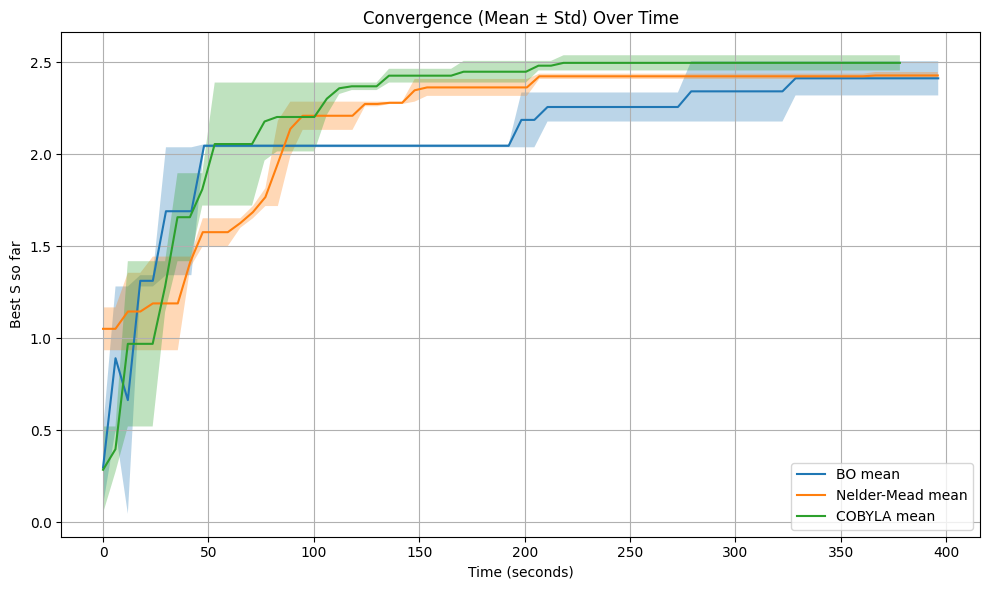

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

plt.plot(BO_time_mean, BO_mean, label='BO mean')
plt.fill_between(BO_time_mean, BO_mean - BO_std, BO_mean + BO_std, alpha=0.3)

plt.plot(NM_time_mean, NM_mean, label='Nelder-Mead mean')
plt.fill_between(NM_time_mean, NM_mean - NM_std, NM_mean + NM_std, alpha=0.3)

plt.plot(COB_time_mean, COB_mean, label='COBYLA mean')
plt.fill_between(COB_time_mean, COB_mean - COB_std, COB_mean + COB_std, alpha=0.3)

plt.xlabel('Time (seconds)')
plt.ylabel('Best S so far')
plt.title('Convergence (Mean ± Std) Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()